### <center>Universidad Autónoma de Nuevo León</center>
# <center>Supplier evaluation and selection in NPI process using a fuzzy logic model</center>
#### <center>Saúl R. Morales <a href="https://orcid.org/0000-0002-1120-7141"><img src="/orcid_logo.png" width="20" height="20"></a> © 2025</center>

This Jupyter Notebook contains the code used for the implementation of the fuzzy logic model in the my thesis for master's degree in Logistics and Supply Chain.

### Module import
In this code section the required modules are imported:
* __*date*__ to create a simulated NPI project. `Project`class requires milestone dates in `Date` class (format).
* __*matplotlib*__ to plot the fuzzy functions.
* __*numpy*__ to work with values in fuzzy variables.
* __*simulation*__ is a custom module with the required classes to simulate the NPI Sourcing process. The code can be found in `simulation.py`.
* __*skfuzzy*__ is a fuzzy logic framework for Python.

In [1]:
from datetime import date
from math import ceil, floor
from statistics import mean, stdev
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import simulation
import skfuzzy as fuzzy
import threading

## 1. Training dataset
In this section a simulated dataset will be generated based in real-world statistics to determine the fuzzy functions of the model in [Section 2](#2.-Fuzzy-model-implementation).

**Table of contents**

[1.1. Generate sample suppliers](#1.1.-Generate-sample-suppliers)

[1.2. Create project and ECNs](#1.2.-Create-project-and-ECNs)

[1.3. Generating data frame](#1.3.-Generating-data-frame)

### 1.1. Generate sample suppliers
Based in fuzzy variables (delivery time, quotation time, price, punctuality) and their values (low, regular, high), it will be necessary to generate 81 suppliers with different profiles each one, aiming to obtain a initial data frame with unbiased data.
Supplier/profile quantity is calculated as follows in this formula: $`R_{max} = \prod_{i=1}^{n} m_{i} = \prod_{i=1}^{4} 3 = 3^{4} = 81`$

The generated suppliers will be named as Supplier 1, Supplier 2, …, Supplier 81; however, from this list of 81 suppliers, three of them containing the profile of the current real-world suppliers will be named different to easily identify them (see table below).

| Supplier ID | Supplier name | Delivery time | Quotation time | Price | Punctuality |
|:-----------:|---------------|:-------------:|:--------------:|:-----:|:-----------:|
| 10000036 | Tuberías ABC, S.A. de C.V. | regular | low | high | high|
| 10000047 | Tuberías DEF, S.A. | regular | high | low | regular |
| 10000073 | Tuberías GHI, S. de R.L. de C.V. | high | high | low | low |

In [2]:
env = simulation.Environment()  # Initialize environment for the simulation.

current_supplier_names = ("Tuberías ABC, S.A. de C.V.", "Tuberías DEF, S.A.", "Tuberías GHI, S. de R.L. de C.V.")
current_Supplier_ids = []
current_supplier_profile = (("regular", "low", "high", "high"), ("regular", "high", "low", "regular"), ("high", "high", "low", "low"))

for delivery_time in ["low", "regular", "high"]:
	for quotation_time in ["low", "regular", "high"]:
		for price in ["low", "regular", "high"]:
			for punctuality in ["low", "regular", "high"]:
				if (delivery_time, quotation_time, price, punctuality) in current_supplier_profile:
					supplier_index = current_supplier_profile.index((delivery_time, quotation_time, price, punctuality))
					supplier_name = current_supplier_names[supplier_index]
					supplier_id = f"1{str(simulation.Supplier.instances + 1).zfill(7)}"
					print(f"{supplier_name} has ID {supplier_id}.")
					current_Supplier_ids.append(supplier_id)
				else:
					supplier_name = f"Supplier {simulation.Supplier.instances + 1}"   # Generate a supplier name concatenating Supplier and supplier number.

				supplier = simulation.Supplier(supplier_name, delivery_time, quotation_time, price, punctuality)
				env.add_supplier(supplier)  # Add supplier to simulation environment.

Tuberías ABC, S.A. de C.V. has ID 10000036.
Tuberías DEF, S.A. has ID 10000047.
Tuberías GHI, S. de R.L. de C.V. has ID 10000073.


### 1.2. Create project and ECNs
Create two sample projects named *Alaska* and *Pandora*.
It is important to define the milestone dates for these projectss. Required milestone dates are:
* **Design freeze (DF):** Restrict not important changes to the design of the project. Most of ECNs (Engineering Change Notification) are released near this date.
* **MCS:** I do not remember what does it stands for in this moment. In this stage a prototype containing the exact sourced material for the project to review to review their feasibility and adjust parameters in case it is needed. In this stage, part numbers do not need to be PPAP approved and built units cannot be sold.
* **Pilot:** In this stage a small but significant quantity of units of the project are produced. It aims to test the whole manufacturing process. All the material needs to be PPAP approved in this stage. Pilot units may be sold under Marketing approval.
* **Start of production (SOP):** Project implementation. Suppliers need to be ready at least six weeks before this date, however, *supplier readiness* may be longer depending on material lead time.

A quantity of 300 ECNs is created for this initial data frame. Each ECN contains a variable quantity of part numbers of different kinds. The quantity and kinds are randomly generated taking into account real statistics.

The simulated part numbers are copper tubes. From a real data set it was determined six kinds three complexity degrees (low, medium, regular). Both parameters affect prices and quantities.

In [3]:
alaska = simulation.Project(
    name="Alaska",
    df_date=date(2024,5,10), 
    mcs_date=date(2024,7,15),
    pilot_date=date(2024,9,1), 
    sop_date=date(2025,1,27)
)   # Create project Alaska.

pandora = simulation.Project(
    name="Pandora",
    df_date=date(2025,8,19),
    mcs_date=date(2026,2,5),
    pilot_date=date(2026,4,23),
    sop_date=date(2026,6,26)
)   # Create project Pandora.

env.gen_ecns(alaska, 100)   # Create 100 ECNs for Alaska project.
env.gen_ecns(pandora, 200)  # Create 200 ECNs for Pandora project.

thread_1 = threading.Thread(target=env.quote_all_ecn_project_all_suppliers, args=(alaska,))
thread_2 = threading.Thread(target=env.quote_all_ecn_project_all_suppliers, args=(pandora,))
thread_1.start()
thread_2.start()
thread_1.join()
thread_2.join()

thread_3 = threading.Thread(target=env.gen_initial_item_master_df_project, args=(alaska,))
thread_4 = threading.Thread(target=env.gen_initial_item_master_df_project, args=(pandora,))
thread_3.start()
thread_4.start()
thread_4.join()
thread_4.join()

env.item_master # Display all the dataframe, with no filters.

/Users/rubusarbaro/.pyProjects/supplier-selection_fuzzy-logic_thesis/simulation.py:741: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2026-03-26' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.item_master.loc[
/Users/rubusarbaro/.pyProjects/supplier-selection_fuzzy-logic_thesis/simulation.py:741: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-05-21' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.item_master.loc[
/Users/rubusarbaro/.pyProjects/supplier-selection_fuzzy-logic_thesis/simulation.py:741: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2026-04-05' has dtype incompatible with float64, please explicitly cast to a compatible dtype first

,Project,ECN,ECN release,Part number,Complexity,EAU,Delivery profile,Quotation profile,Price profile,Punctuality profile,...,PPAP approval,Contract date,Quotation time,OTD,Delivery time,FY Spend,Awarded,MCS ready,Pilot ready,SOP ready
0,Alaska,ECN0000001,2024-03-22,A0A000001,low,48.0,low,low,low,low,...,NaN,NaN,31.0,NaN,NaN,1018.56,0.0,NaN,NaN,NaN
1,Alaska,ECN0000001,2024-03-22,A0A000002,low,48.0,low,low,low,low,...,NaN,NaN,31.0,NaN,NaN,1068.48,0.0,NaN,NaN,NaN
2,Alaska,ECN0000001,2024-03-22,A0C000001,low,48.0,low,low,low,low,...,NaN,NaN,31.0,NaN,NaN,828.96,0.0,NaN,NaN,NaN
3,Alaska,ECN0000001,2024-03-22,A0A000001,low,48.0,low,low,low,regular,...,NaN,NaN,35.0,NaN,NaN,288.96,False,NaN,NaN,NaN
4,Alaska,ECN0000001,2024-03-22,A0A000002,low,48.0,low,low,low,regular,...,NaN,NaN,35.0,NaN,NaN,453.12,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52036,Pandora,ECN0000300,2025-12-27,A0G000088,high,101.0,high,high,high,regular,...,NaN,NaN,11.7,NaN,NaN,12786.60,False,NaN,NaN,NaN
52037,Pandora,ECN0000300,2025-12-27,A0D000105,medium,101.0,high,high,high,high,...,NaN,NaN,32.0,NaN,NaN,8097.17,False,NaN,NaN,NaN
52038,Pandora,ECN0000300,2025-12-27,A0E000278,high,101.0,high,high,high,high,...,NaN,NaN,32.0,NaN,NaN,13513.80,False,NaN,NaN,NaN
52039,Pandora,ECN0000300,2025-12-27,A0E000279,high,101.0,high,high,high,high,...,NaN,NaN,32.0,NaN,NaN,10687.82,False,NaN,NaN,NaN


### 1.3. Generating data frame
Generate the data frame is divided in two steps:
1. Quoting all the ECNs with all the suppliers. The simulation uses real statistical data to generate random dates and prices.
2. Implementing each ECN with random chosen suppliers. A uniform distribution is used to randomly chose the suppliers.

## 2. Fuzzy model implementation
### 2.1. Generate dataset for fuzzy model
In this section a new project and data frame containing 10 copper piping ECNs is generated to apply it with the 

In [4]:
juneau = simulation.Project(
    name="Juneau",
    df_date=date(2024,4,9),
    mcs_date=date(2024,6,17),
    pilot_date=date(2024,8,1),
    sop_date=date(2024,11,25)
)

juneau_ecns = env.gen_ecns(juneau, 10)

for supplier in env.suppliers:
    if supplier.id not in current_Supplier_ids:
        env.deactivate_supplier(supplier)


## 0. Experiment

/Users/rubusarbaro/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


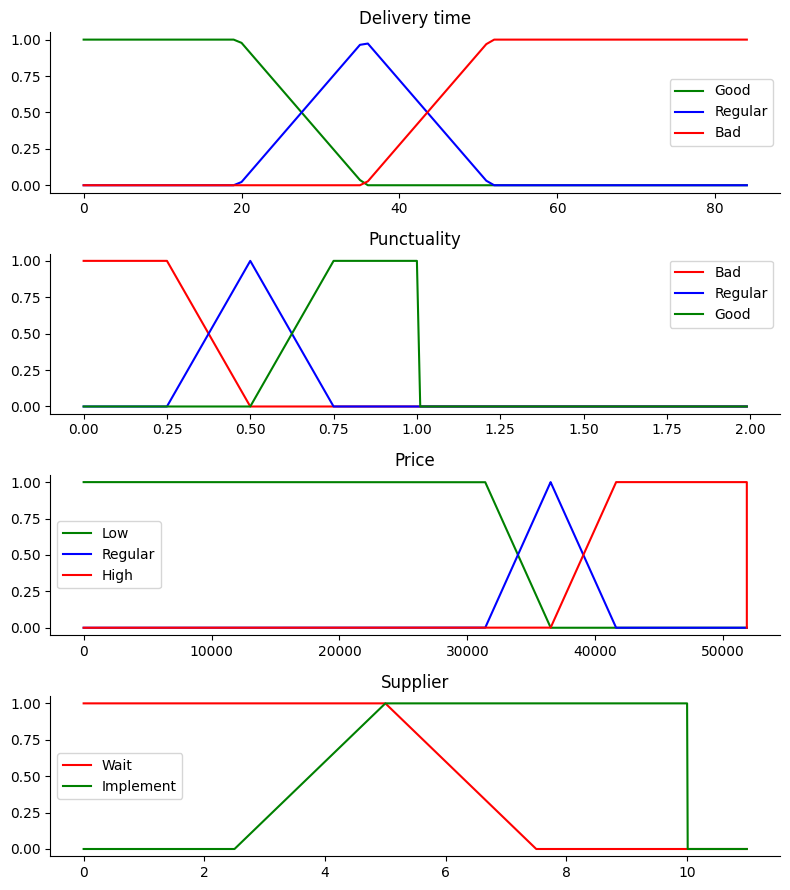

In [5]:
evaluator = simulation.Fuzzy_Model(env.item_master)
evaluator.plot()

In [6]:
from datetime import timedelta
import colors

ecn_dates = []
for ecn in juneau_ecns:
    ecn_dates.append(ecn.ecn_date)

clock = min(ecn_dates)
initial_classification = True
ecn_status = {
    "Not released": [],
    "Quoting": [],
    "Implemented": []
} # Not released, Quoting

fuzzy_evaluation = pd.DataFrame(data=None, columns=["ECN", "Supplier ID", "Score", "Wait", "Implement", "Action"])

continue_simulation = True
while continue_simulation:
    while initial_classification:
        for ecn in juneau.ecns:
            ecn_status["Not released"].append(ecn)
        initial_classification = False

    for ecn in ecn_status["Not released"]:
        if ecn.ecn_date == clock:
            env.quote_ecn_all_suppliers(ecn)
            print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {ecn.ecn_id} Released. RFQ sent.")
            ecn_status["Quoting"].append(ecn)
            ecn_status["Not released"].remove(ecn)
            
    for ecn in ecn_status["Quoting"]:
        if len(fuzzy_evaluation[(fuzzy_evaluation["ECN"] == ecn.ecn_id)]) == len(env.active_suppliers):
            max_score = fuzzy_evaluation[fuzzy_evaluation["ECN"] == ecn.ecn_id]["Score"].max()
            max_score_supplier_id = fuzzy_evaluation[(fuzzy_evaluation["ECN"] == ecn.ecn_id) & (fuzzy_evaluation["Score"] == max_score)]["Supplier ID"]
            env.implement_ecn(ecn, env.get_supplier("id", max_score_supplier_id))
            ecn_status["Implemented"].append(ecn)
            ecn_status["Quoting"].remove(ecn)
            print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {quotation.supplier.name} awarded for {ecn.ecn_id}.")
        else:
            for quotation in ecn.quotations:
                if quotation.date == clock:
                    supplier_id = quotation.supplier.id
                    print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {ecn.ecn_id} quotation received from {supplier_id}.")
                            
                    stats = evaluator.evaluate_supplier(quotation.supplier, ecn)
                    fuzzy_evaluation.loc[len(fuzzy_evaluation)] = [ecn.ecn_id, stats["Supplier ID"], stats["Score"], stats["Wait"], stats["Implement"], stats["Action"]]
                    print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {quotation.supplier.name} score is {stats['Score']}")

                    if stats["Action"] == "Implement":
                        env.implement_ecn(ecn, quotation.supplier)
                        ecn_status["Implemented"].append(ecn)
                        ecn_status["Quoting"].remove(ecn)
                        print(f"{colors.Regular.bold}{clock}:{colors.Text.end} {quotation.supplier.name} awarded for {ecn.ecn_id}.")
    
    if len(ecn_status["Not released"]) == 0 and len(ecn_status["Quoting"]) == 0:
        continue_simulation = False
    else:
        clock += timedelta(days=1)

2024-01-10: ECN0000301 Released. RFQ sent.
2024-01-31: ECN0000301 quotation received from 10000073.


EmptyMembershipError: The membership function area is empty.

## Define parameters for fuzzy variables

In [ ]:
max_delivery_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Delivery time"].max())
max_quotation_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Quotation time"].max())
µ_business_total = float(env.item_master[(env.item_master["Project"] == "Juneau")][["Supplier name", "FY Spend"]].groupby("Supplier name").sum().mean())
σ_business_total = float(env.item_master[(env.item_master["Project"] == "Juneau")][["Supplier name", "FY Spend"]].groupby("Supplier name").sum().std())
min_business_total = µ_business_total - 3*σ_business_total
max_business_total = µ_business_total + 3*σ_business_total

var_delivery_time = np.arange(0, max_delivery_time + 1, 1)
var_quotation_time = np.arange(0, max_quotation_time + 1, 1)
var_price = np.arange(floor(µ_business_total - 3*σ_business_total), ceil(µ_business_total + 3*σ_business_total), 0.01)
var_punctuality = np.arange(0, 2, 0.01)
var_supplier = np.arange(0, 11, 0.01)

µ_delivery_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Delivery time"].mean())
σ_delivery_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Delivery time"].std())

µ_quotation_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Quotation time"].mean())
σ_quotation_time = round(env.item_master[(env.item_master["Awarded"] == True)]["Quotation time"].std())

µ_punctuality_low, σ_punctuality_low = get_μσ_punctuality("low")
µ_punctuality_medium, σ_punctuality_medium = get_μσ_punctuality("regular")
µ_punctuality_high, σ_punctuality_high = get_μσ_punctuality("high")

delivery_time_low = fuzzy.trapmf(var_delivery_time, [0, 0, µ_delivery_time - σ_delivery_time, µ_delivery_time])
delivery_time_medium = fuzzy.trimf(var_delivery_time, [µ_delivery_time - σ_delivery_time, µ_delivery_time, µ_delivery_time + σ_delivery_time])
delivery_time_high = fuzzy.trapmf(var_delivery_time, [µ_delivery_time, µ_delivery_time + σ_delivery_time, max_delivery_time, max_delivery_time])

quotation_time_low  = fuzzy.trapmf(var_quotation_time, [0, 0, µ_quotation_time - σ_quotation_time, µ_quotation_time])
quotation_time_medium  = fuzzy.trimf(var_quotation_time, [µ_quotation_time - σ_quotation_time, µ_quotation_time, µ_quotation_time + σ_quotation_time])
quotation_time_high = fuzzy.trapmf(var_quotation_time, [µ_quotation_time, µ_quotation_time + σ_quotation_time, max_quotation_time, max_quotation_time])

punctuality_low = fuzzy.trapmf(var_punctuality, [0, 0, 0.25, 0.5])
punctuality_medium = fuzzy.trimf(var_punctuality, [0.25, 0.5, 0.75])
punctuality_high = fuzzy.trapmf(var_punctuality, [0.5, 0.75, 1, 1])

price_low = fuzzy.trapmf(var_price, [floor(min_business_total), floor(min_business_total), round(µ_business_total - σ_business_total), round(μ_business_total)])
price_medium = fuzzy.trimf(var_price, [round(μ_business_total - σ_business_total), round(μ_business_total), round(μ_business_total + σ_business_total)])
price_high = fuzzy.trapmf(var_price, [round(μ_business_total), round(μ_business_total + σ_business_total), ceil(max_business_total), ceil(max_business_total)])

supplier_low = fuzzy.trimf(var_supplier, [0, 2.5, 5])
supplier_medium = fuzzy.trimf(var_supplier, [2.5, 5, 7.5])
supplier_high = fuzzy.trimf(var_supplier, [5, 7.5, 10])

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, figsize=(8, 9))

ax0.plot(var_delivery_time, delivery_time_low, "b", linewidth=1.5, label="Good")
ax0.plot(var_delivery_time, delivery_time_medium, "g", linewidth=1.5, label="Regular")
ax0.plot(var_delivery_time, delivery_time_high, "r", linewidth=1.5, label="Bad")
ax0.set_title("Delivery time")
ax0.legend()

ax1.plot(var_quotation_time, quotation_time_low, "b", linewidth=1.5, label="Good")
ax1.plot(var_quotation_time, quotation_time_medium, "g", linewidth=1.5, label="Regular")
ax1.plot(var_quotation_time, quotation_time_high, "r", linewidth=1.5, label="Bad")
ax1.set_title("Quotation time")
ax1.legend()

ax2.plot(var_punctuality, punctuality_low, "b", linewidth=1.5, label="Bad")
ax2.plot(var_punctuality, punctuality_medium, "g", linewidth=1.5, label="Regular")
ax2.plot(var_punctuality, punctuality_high, "r", linewidth=1.5, label="Good")
ax2.set_title("Punctuality")
ax2.legend()

ax3.plot(var_price, price_low, "b", linewidth=1.5, label="Low")
ax3.plot(var_price, price_medium, "g", linewidth=1.5, label="Regular")
ax3.plot(var_price, price_high, "r", linewidth=1.5, label="High")
ax3.set_title("Price")
ax3.legend()

ax4.plot(var_supplier, supplier_low, "b", linewidth=1.5, label="Bad")
ax4.plot(var_supplier, supplier_medium, "g", linewidth=1.5, label="Regular")
ax4.plot(var_supplier, supplier_high, "r", linewidth=1.5, label="Good")
ax4.set_title("Supplier")
ax4.legend()

for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
plt.show()

In [ ]:
new_juneau_ecns = env.gen_ecns(juneau, 10)

In [ ]:
for ecn in new_juneau_ecns:
    env.quote_ecn_all_suppliers(ecn)

In [ ]:
estrella = simulation.Supplier("Súper Proveedor, S.A.S.", "low", "low", "low", "high")
env.add_supplier(estrella)

In [ ]:
for ecn in new_juneau_ecns:
    env.quote_ecn_some_suppliers(ecn, [estrella])

In [ ]:
analyse_ecns = []

for ecn in new_juneau_ecns:
    analyse_ecns.append(ecn.ecn_id)

In [ ]:
env.item_master[env.item_master["Supplier ID"] == estrella.id]

In [ ]:
env.item_master.groupby(["ECN", "Supplier ID"])[["Price"]].sum().max()

In [ ]:
197+158

### Price

**Low** (Average/Min/Max) **:** 165/34/296

**Regular** (Average/Min/Max) **:** 195/43/347

**High** (Average/Min/Max) **:** 232/51/413


In [ ]:
evaluation_supplier_id = "10000082"

crisp_delivery_time = env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id) & (env.item_master["Awarded"] == True)]["Delivery time"].mean()
crisp_quotation_time = env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id)]["Quotation time"].mean()
crisp_price = env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Supplier ID"] == evaluation_supplier_id)]["FY Spend"].sum()
#crisp_price = env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Supplier ID"] == evaluation_supplier_id) & env.item_master["ECN"].isin(analyse_ecns)]["FY Spend"].sum()
try:
    crisp_punctuality = len(env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id) & (env.item_master["Awarded"] == True) & (env.item_master["OTD"] == True)]) / len(env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id) & (env.item_master["Awarded"] == True)])
    new_supplier = False
except:
    new_supplier = True
    crisp_delivery_time = env.item_master[(env.item_master["Supplier ID"] == evaluation_supplier_id) & (env.item_master["ECN"].isin(analyse_ecns))]["Lead time"].mean()

# Assign membership degree
price_level_low = fuzzy.interp_membership(var_price, price_low, crisp_price)
price_level_medium = fuzzy.interp_membership(var_price, price_medium, crisp_price)
price_level_high = fuzzy.interp_membership(var_price, price_high, crisp_price)

if not new_supplier:
    punctuality_level_low = fuzzy.interp_membership(var_punctuality, punctuality_low, crisp_punctuality)
    punctuality_level_medium = fuzzy.interp_membership(var_punctuality, punctuality_medium, crisp_punctuality)
    punctuality_level_high = fuzzy.interp_membership(var_punctuality, punctuality_high, crisp_punctuality)

delivery_time_level_low = fuzzy.interp_membership(var_delivery_time, delivery_time_low, crisp_delivery_time)
delivery_time_level_medium = fuzzy.interp_membership(var_delivery_time, delivery_time_medium, crisp_delivery_time)
delivery_time_level_high = fuzzy.interp_membership(var_delivery_time, delivery_time_high, crisp_delivery_time)

quotation_time_level_low = fuzzy.interp_membership(var_quotation_time, quotation_time_low, crisp_quotation_time)
quotation_time_level_medium = fuzzy.interp_membership(var_quotation_time, quotation_time_medium, crisp_quotation_time)
quotation_time_level_high = fuzzy.interp_membership(var_quotation_time, quotation_time_high, crisp_quotation_time)

# Rule application
# Example code uses np.fmax for OR operator. I will use np.fmin for AND.
if new_supplier:
    rule_1 = np.fmin.reduce([delivery_time_level_low, quotation_time_level_low, price_level_low])

    rule_2 = np.fmin.reduce([delivery_time_level_medium, quotation_time_level_low, price_level_low])

    rule_3 = np.fmin.reduce([delivery_time_level_low, quotation_time_level_medium, price_level_low])

    rule_4 = np.fmin.reduce([delivery_time_level_low, quotation_time_level_low, price_level_medium])

    rule_5 = np.fmin.reduce([delivery_time_level_high, quotation_time_level_high, price_level_high])

    rule_6 = np.fmin.reduce([delivery_time_level_medium, quotation_time_level_high, price_level_high])

    rule_7 = np.fmin.reduce([delivery_time_level_high, quotation_time_level_medium, price_level_high])

    rule_8 = np.fmin.reduce([delivery_time_level_medium, quotation_time_level_high, price_level_medium])

    rule_9 = 1 - np.fmax.reduce([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8])

    supplier_activation_low = np.fmin(np.fmax.reduce([rule_5, rule_6, rule_7, rule_8]), supplier_low)
    supplier_activation_medium = np.fmin(rule_9, supplier_medium)
    supplier_activation_high = np.fmin(np.fmax.reduce([rule_1, rule_2, rule_3, rule_4]), supplier_high)
else:
    rule_1 = np.fmin.reduce([delivery_time_level_low, quotation_time_level_low, price_level_low, punctuality_level_high])

    rule_2 = np.fmin.reduce([delivery_time_level_medium, quotation_time_level_low, price_level_low, punctuality_level_high])

    rule_3 = np.fmin.reduce([delivery_time_level_low, quotation_time_level_medium, price_level_low, punctuality_level_high])

    rule_4 = np.fmin.reduce([delivery_time_level_low, quotation_time_level_low, price_level_medium, punctuality_level_high])

    rule_5 = np.fmin.reduce([delivery_time_level_low, quotation_time_level_low, price_level_low, punctuality_level_medium])

    rule_6 = np.fmin.reduce([delivery_time_level_high, quotation_time_level_high, price_level_high, punctuality_level_low])

    rule_7 = np.fmin.reduce([delivery_time_level_medium, quotation_time_level_high, price_level_high, punctuality_level_low])

    rule_8 = np.fmin.reduce([delivery_time_level_high, quotation_time_level_medium, price_level_high, punctuality_level_low])

    rule_9 = np.fmin.reduce([delivery_time_level_high, quotation_time_level_high, price_level_medium, punctuality_level_low])

    rule_10 = np.fmin.reduce([delivery_time_level_high, quotation_time_level_medium, price_level_high, punctuality_level_medium])

    rule_11 = 1 - np.fmax.reduce([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8, rule_9, rule_10])

    supplier_activation_low = np.fmin(np.fmax.reduce([rule_6, rule_7, rule_8, rule_9, rule_10]), supplier_low)
    supplier_activation_medium = np.fmin(rule_11, supplier_medium)
    supplier_activation_high = np.fmin(np.fmax.reduce([rule_1, rule_2, rule_3, rule_4, rule_5]), supplier_high)

supplier_0 = np.zeros_like(var_supplier)

aggregated = np.fmax.reduce([supplier_activation_low, supplier_activation_medium, supplier_activation_high])


# Defuzzification
supplier_score = fuzzy.defuzz(var_supplier, aggregated, "centroid")
supplier_activation = fuzzy.interp_membership(var_supplier, aggregated, supplier_score)

fig, (ax5, ax6) = plt.subplots(nrows=2, figsize=(8, 9))

ax5.fill_between(var_supplier, supplier_0, supplier_activation_low, facecolor="b", alpha=0.7)
ax5.plot(var_supplier, supplier_low, "b", linewidth=0.5, linestyle="--")
ax5.fill_between(var_supplier, supplier_0, supplier_activation_medium, facecolor="g", alpha=0.7)
ax5.plot(var_supplier, supplier_medium, "g", linewidth=0.5, linestyle="--")
ax5.fill_between(var_supplier, supplier_0, supplier_activation_high, facecolor="r", alpha=0.7)
ax5.plot(var_supplier, supplier_high, "r", linewidth=0.5, linestyle="--")
ax5.set_title("Output membership")

ax6.plot(var_supplier, supplier_low, "b", linewidth=0.5, linestyle="--")
ax6.plot(var_supplier, supplier_medium, "g", linewidth=0.5, linestyle="--")
ax6.plot(var_supplier, supplier_high, "r", linewidth=0.5, linestyle="--")
ax6.fill_between(var_supplier, supplier_0, aggregated, facecolor="Orange", alpha=0.7)
ax6.plot([supplier_score, supplier_score], [0, supplier_activation], "k", linewidth=1.5, alpha=0.9)
ax6.set_title("Aggregated membership and supplier score (line)")

for ax in [ax5, ax6]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Supplier score: {supplier_score}")

print("Rules:")
for i, rule in enumerate([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8, rule_9, rule_10, rule_11]):
    print(f"Rule {i+1}: {rule:.3f}")

print("\nSupplier activations:")
print(f"Low: {supplier_activation_low.max():.3f}")
print(f"Medium: {supplier_activation_medium.max():.3f}")
print(f"High: {supplier_activation_high.max():.3f}")

print("\nCrisp values")
print(f"Average delivery time: {crisp_delivery_time}")
print(f"Average quotation time: {crisp_quotation_time}")
print(f"Total business cost: {crisp_price}")
print(f"Supplier punctuality: {crisp_punctuality}")

In [ ]:
env.item_master[(env.item_master["Awarded"] == True) & (env.item_master["Supplier ID"] == evaluation_supplier_id)]

In [ ]:
testing_supplier = env.get_supplier("id", "10000082")
otd_sop = []

for i in range(100):
    for ecn in new_juneau_ecns:
        env.implement_ecn(ecn, testing_supplier, overwrite=True)
    
    otd = len(env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Supplier ID"] == testing_supplier.id) & (env.item_master["Awarded"] == True) & (env.item_master["SOP ready"] == True)]) / len(env.item_master[(env.item_master["Project"] == "Juneau") & (env.item_master["Supplier ID"] == testing_supplier.id) & (env.item_master["Awarded"] == True)])

    otd_sop.append(otd)

mean(otd_sop)